In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

from PIL import Image

from torch.utils.data import Dataset, DataLoader, Sampler
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.io import read_image 
from torchvision.transforms import Compose, Resize, RandomVerticalFlip, RandomHorizontalFlip, ColorJitter, Grayscale, Normalize
import torchvision.models as models

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DEFAULT_RANDOM_SEED = 42

def set_all_seeds(seed=DEFAULT_RANDOM_SEED):

    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # torch's seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(seed=DEFAULT_RANDOM_SEED)

In [3]:
train = pd.read_csv('/kaggle/input/hsexvk-hack/train.csv')
test = pd.read_csv('/kaggle/input/hsexvk-hack/test.csv')
sample = pd.read_csv('/kaggle/input/hsexvk-hack/sample_submission.csv')
train_data_dir = '/kaggle/input/hsexvk-hack/train_data/'
test_data_dir = '/kaggle/input/hsexvk-hack/test_data/'

In [4]:
class SquareDataset(Dataset):
    def __init__(self, images_dir:str, df:pd.DataFrame, transform=None, mode:str='train'):
        
        self.df = df
        self.images_dir = images_dir
        self.image_names = df.iloc[:, 0].values
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_names[idx])
        image = read_image(img_name).float() 
        if self.mode != 'test':
            label = self.df.iloc[:, 1].values[idx]

        if self.transform:
            image = self.transform(image)

        if self.mode != 'test':
            return image, img_name, np.float32(label)
        else:
            return image, img_name

In [5]:
# train, val = train_test_split(train, test_size=0.2, random_state=42)

In [6]:
transforms = Compose([
    RandomVerticalFlip(),
    RandomHorizontalFlip(),
    ColorJitter(),
    Resize((224, 224), antialias=True),
])
other_transforms = Compose([
    Resize((224, 224), antialias=True),
])

train_dataset = SquareDataset(train_data_dir, train, transform=transforms)
# val_dataset = SquareDataset(train_data_dir, val, transform=other_transforms, mode='val')
test_dataset = SquareDataset(test_data_dir, test, transform=other_transforms, mode='test')

In [7]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [8]:
NUM_CLASSES = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# mobilenetv3-small
# model = models.mobilenet_v3_small(pretrained=True)
# model.classifier[3] = nn.Linear(in_features=1024, out_features=1, bias=True)
# model = model.to(device)

# mobilenetv3-large
# model = models.mobilenet_v3_large(pretrained=True)
# model.classifier[3] = nn.Linear(in_features=1280, out_features=1, bias=True)
# model = model.to(device)

#alexnet
# model = models.alexnet(pretrained=True)
# model.classifier[6] = nn.Linear(in_features=4096, out_features=1, bias=True)
# device = torch.device('cuda:1')
# model = model.to(device)

# efficientnet-b0
# model = models.efficientnet_b1(pretrained=True)
# model.classifier[1] = nn.Linear(in_features=1280, out_features=1, bias=True)
# model = model.to(device)

#efficientnet-b3
# model = models.efficientnet_b3(pretrained=True)
# model.classifier[1] = nn.Linear(in_features=1536, out_features=1, bias=True)
# model = model.to(device)

# mobilenet-v2 best
model = models.mobilenet_v2(pretrained=True)
# model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)
model = model.to(device)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 118MB/s]


In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
milestones = [10, 13, 18, 24, 27, 30, 35]
gamma = 0.3
exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=gamma)

In [24]:
def run_epoch(model, optimizer, exp_lr_scheduler, data_loader, mode):
    cumulative_loss = 0.0
    count = 0
    
    if mode == 'train':
        model.train()
    else:
        model.eval()

    for data, name, target in tqdm(data_loader):
        data, target = data.to(device), target.to(device)

        outputs = model(data).squeeze()
        loss = criterion(outputs, target)

        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        cumulative_loss += loss.item()*len(target)
        count += len(target)

    if mode == 'train':
        exp_lr_scheduler.step()

    rmse = np.sqrt(cumulative_loss / count)
    return rmse
    

def train_model(model, optimizer, exp_lr_scheduler, data_loaders, epochs=30):
    train_history = []
#     val_history = []
    
#     best_rmse = float('inf')
    best_model_path = None
    for epoch in range(epochs):
        train_rmse = run_epoch(model, optimizer, exp_lr_scheduler, data_loaders['train'], 'train')
#         val_rmse = run_epoch(model, optimizer, exp_lr_scheduler, data_loaders['val'], 'val')

        train_history.append(train_rmse)
#         val_history.append(val_rmse)

        print(f'Epoch {epoch}')
        print(f'Train RMSE: {train_rmse:.3f}')
#         print(f'Val RMSE: {val_rmse:.3f}', end='\n\n')

#         if val_rmse < best_rmse:
#             best_rmse = val_rmse
#             best_model_path = f'best_model_epoch_{epoch}.pth'
#             torch.save(model.state_dict(), best_model_path)

#     model.load_state_dict(torch.load(best_model_path))
    return model, train_history#, val_history

In [25]:
model, train_history = train_model(
    model, 
    optimizer, 
    exp_lr_scheduler, 
    {'train': train_dataloader}, 
    epochs=15
)

  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 0
Train RMSE: 0.345


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1
Train RMSE: 0.342


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2
Train RMSE: 0.335


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3
Train RMSE: 0.348


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4
Train RMSE: 0.340


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5
Train RMSE: 0.337


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6
Train RMSE: 0.339


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7
Train RMSE: 0.325


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8
Train RMSE: 0.333


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9
Train RMSE: 0.333


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10
Train RMSE: 0.323


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11
Train RMSE: 0.334


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12
Train RMSE: 0.320


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13
Train RMSE: 0.315


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14
Train RMSE: 0.309


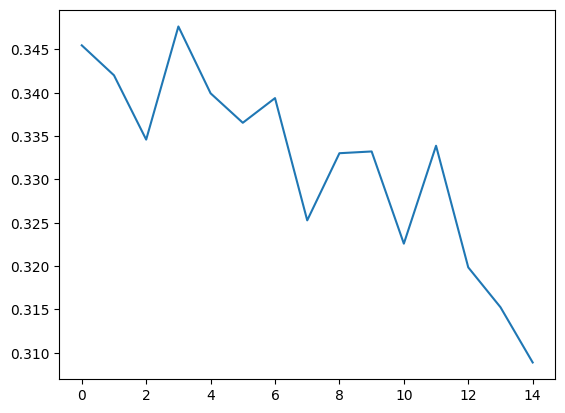

In [26]:
plt.plot(train_history)
# plt.plot(val_history)
plt.show()

In [27]:
def get_prediction(model):
    model.eval()
    predictions = []
    for batch_idx, (data, name) in tqdm(enumerate(test_dataloader)):
        data = data.to(device)
        outputs = model(data)
        predictions.append(outputs.detach().cpu().numpy())
    return predictions

In [28]:
preds = get_prediction(model)

0it [00:00, ?it/s]

In [33]:
pd.DataFrame(np.concatenate(preds).reshape(-1), columns=['label']).to_csv('/kaggle/working/mobv2_full_4.csv', index=False)

In [ ]:
best_model_path = '/kaggle/working/best_model.pth'
torch.save(model.state_dict(), best_model_path)

In [ ]:
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [ ]:
from tqdm import tqdm
import os

In [ ]:
question = 'how many squares inside the image?'
answers_test = []
for image_name in tqdm([f'{i+1}.png' for i in range(6000)]):
    image = Image.open('/kaggle/input/hsexvk-hack/test_data/test_data/' + image_name)
    encoding = processor(image, text, return_tensors="pt")
    outputs = model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()
    answers_test.append(model.config.id2label[idx])

In [ ]:
last_df = pd.DataFrame({'label': answers_test})

In [ ]:
last_df.to_csv('/kaggle/working/vqa_1.csv', index=False)

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
int_answers = [int(x) - 4 for x in answers]
true_answers = train['label'].values.tolist()
print(np.sqrt(mean_squared_error(true_answers, int_answers)))

In [ ]:
image = Image.open('/kaggle/input/hsexvk-hack/train_data/train_data/1024.png')
question = 'how many squares inside the image?'

inputs = processor(image, question, return_tensors="pt")

out = model.generate(**inputs, num_beams=2, )
print(processor.decode(out[0], skip_special_tokens=True))

# text = question
# encoding = processor(image, text, return_tensors="pt")

# outputs = model(**encoding)
# logits = outputs.logits
# idx = logits.argmax(-1).item()
# print(model.config.id2label[idx])

In [ ]:
image = Image.open('/kaggle/input/hsexvk-hack/train_data/train_data/1024.png')
image